<a href="https://colab.research.google.com/github/BehnamLatifi/Sample-Project/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

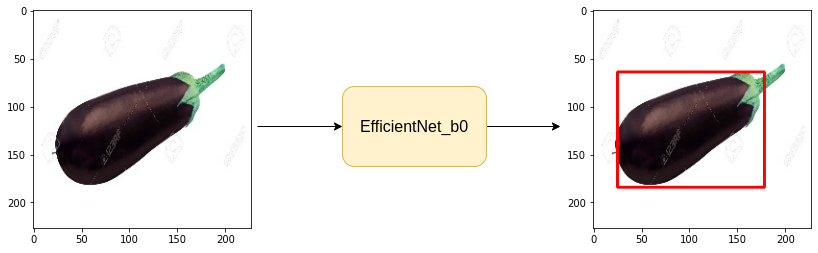

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

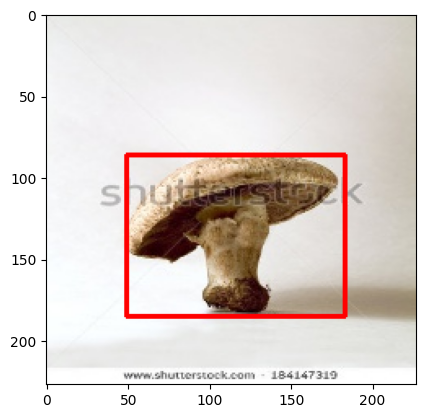

In [ ]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img);

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.
    bbox = torch.Tensor(bbox)
    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f'Total examples in the trainset : {len(trainset)}')
print(f'Total examples in the validset : {len(validset)}')

Total examples in the trainset : 148
Total examples in the validset : 38


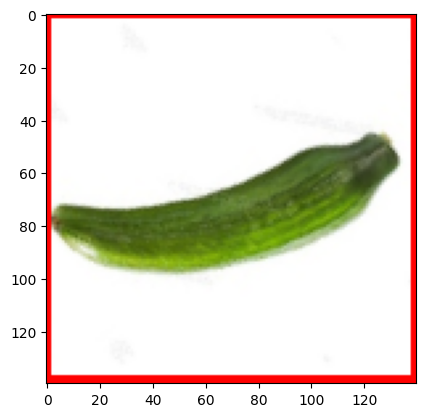

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img);

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(
        MODEL_NAME, pretrained = True, num_classes = 4
    )

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.
  model.train()
  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()
    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('WEIGHTS-ARE-SAVED')
    best_valid_loss = valid_loss
  print(f'Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 1 train loss : 5531.85615234375 valid loss : 3938.6988118489585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 train loss : 2002.4322998046875 valid loss : 4898.393717447917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 3 train loss : 1105.5389099121094 valid loss : 1022.6761067708334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 4 train loss : 748.7951629638671 valid loss : 214.36255900065103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 5 train loss : 539.3827819824219 valid loss : 166.00424194335938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss : 380.7227844238281 valid loss : 255.60059102376303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss : 271.84275512695314 valid loss : 185.04503377278647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 8 train loss : 217.01374053955078 valid loss : 144.0770263671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 9 train loss : 198.26327362060547 valid loss : 120.78521982828777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 10 train loss : 134.63501358032227 valid loss : 116.76084899902344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss : 115.20403823852538 valid loss : 162.15087127685547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss : 120.72757186889649 valid loss : 133.45564778645834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 13 train loss : 96.53300476074219 valid loss : 107.25137837727864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 14 train loss : 80.95917320251465 valid loss : 98.3667475382487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss : 79.55559997558593 valid loss : 120.03431193033855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 16 train loss : 66.41824455261231 valid loss : 94.99894205729167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 61.07015724182129 valid loss : 105.88790384928386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss : 64.83529815673828 valid loss : 100.67767842610677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 19 train loss : 54.89322986602783 valid loss : 76.63934961954753


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 55.46314544677735 valid loss : 120.13833872477214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 50.3790205001831 valid loss : 86.51414616902669


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss : 41.41102523803711 valid loss : 114.27798716227214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 57.504356384277344 valid loss : 109.46905771891277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss : 53.75464572906494 valid loss : 109.62429173787434


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 51.81330909729004 valid loss : 77.11963526407878


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss : 65.05029373168945 valid loss : 115.74164581298828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 27 train loss : 51.405443572998045 valid loss : 67.82220204671223


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 28 train loss : 55.20454845428467 valid loss : 66.29471588134766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 60.110562324523926 valid loss : 73.5184809366862


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 44.388522148132324 valid loss : 92.6881612141927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 46.88860530853272 valid loss : 102.7936274210612


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 44.38859634399414 valid loss : 82.46295420328777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 45.30553131103515 valid loss : 79.70209248860677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 46.94970760345459 valid loss : 92.94325129191081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 35 train loss : 41.458749008178714 valid loss : 64.50059636433919


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 40.23991374969482 valid loss : 65.38036346435547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 41.05362758636475 valid loss : 69.99312591552734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 46.36390323638916 valid loss : 79.32893371582031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 34.165442848205565 valid loss : 89.11968994140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 40 train loss : 47.25243701934814 valid loss : 59.542128245035805


#Inference

In [ ]:
import utils

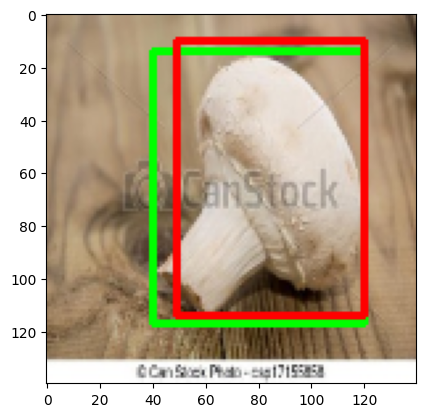

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[23]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)
  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya